Устройство автомобильных номеров Китая можно найти по ссылке: https://prochinamarket.livejournal.com/4326.html?ysclid=luzmzdv19k782358972 или https://rcit.su/inform-avto.html?ysclid=luzn7he0vs888630517

In [1]:
characters_dict = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 
    'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 
    'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, '京': 36, '警': 37, '国': 38, '沪': 39, '渝': 40, '冀': 41, '豫': 42, '云': 43, 
    '辽': 44, '黑': 45, '湘': 46, '皖': 47, '鲁': 48, '新': 49, '苏': 50, '浙': 51, '赣': 52, '鄂': 53, '桂': 54, '甘': 55, '晋': 56,
    '蒙': 57, '陕': 58, '吉': 59, '闽': 60, '贵': 61, '粤': 62, '青': 63, '藏': 64, '川': 65, '宁': 66, '琼': 67, '津': 68
}

id2char = dict((v,k) for k,v in characters_dict.items())

In [2]:
from data_reader import LMDBReader, CCPDHelper

# your path to data
train_path = r'/home/syrovatkins/course_ocr/task2/CCPD/train.lmdb'

# Data preparation 

In [3]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = CCPDHelper(train_reader)

In [5]:
train_helper.size()

199996

In [6]:
names = train_reader.namelist()
SEED = 42
TRAIN_PART = 0.8

In [7]:
rng = np.random.default_rng(SEED)
permutation = rng.permutation(len(names))
train_size = int(len(names) * TRAIN_PART)
train_names = [names[i] for i in permutation[:train_size]]
val_names = [names[i] for i in permutation[train_size:]]

In [8]:
train_helper = CCPDHelper(train_reader, train_names)
val_helper = CCPDHelper(train_reader, val_names)

In [9]:
img0, txt0 = train_helper.item(10)

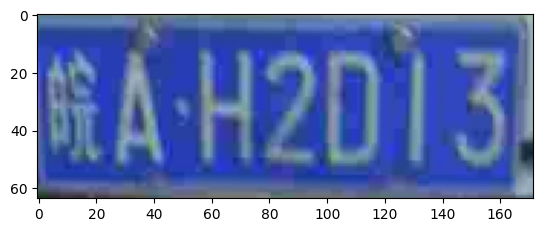

In [10]:
from matplotlib import pyplot as plt
plt.imshow(img0)

Построим распределение регионов

In [11]:
areas = []

for i in tqdm(range(train_size)):
    _, txt = train_helper.item(i)
    areas.append(txt[0])

100%|█| 159996/159996 [00:47<00:00, 334


Дадим меньший вес провинции Анхой (皖), остальным провинциям дадим больший вес:

In [12]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

cnt = Counter(areas)
area_counts = dict(cnt)
weights = {k: 0.5 for k, v in area_counts.items()}
weights['皖'] = 0.1

train_weights = [weights[region] for region in areas]
sampler = WeightedRandomSampler(train_weights, train_size)

In [48]:
area_counts

{'皖': 153423,
 '沪': 525,
 '苏': 2666,
 '鄂': 219,
 '粤': 304,
 '陕': 42,
 '浙': 1074,
 '桂': 12,
 '赣': 119,
 '京': 259,
 '湘': 70,
 '辽': 44,
 '鲁': 204,
 '云': 12,
 '冀': 136,
 '豫': 349,
 '蒙': 15,
 '新': 13,
 '闽': 171,
 '川': 94,
 '渝': 60,
 '晋': 54,
 '甘': 12,
 '黑': 17,
 '琼': 9,
 '吉': 13,
 '津': 54,
 '贵': 12,
 '青': 9,
 '宁': 4,
 '藏': 1}

In [13]:
RGB_mean = [0.485, 0.456, 0.406]
RGB_std  = [0.229, 0.224, 0.225]

def get_train_transforms(img_size):
    train_transforms = transforms.Compose([transforms.ToTensor(),
                                           transforms.Resize(img_size),
                                           transforms.Normalize(mean=RGB_mean, std=RGB_std)])
    return train_transforms


def get_test_transforms(img_size):
    test_transforms = transforms.Compose([transforms.ToTensor(),
                                          transforms.Resize(img_size),
                                          transforms.Normalize(mean=RGB_mean, std=RGB_std)])
    return test_transforms


class CCPDDataset(Dataset):
    def __init__(self, train_helper, characters_dict, img_size=(96, 180), transform='train'):
        self.train_helper = train_helper
        self.characters_dict = characters_dict
        self.img_size = img_size

        if transform == 'train':
            self.transform = get_train_transforms(img_size)
        elif transform == 'test':
            self.transform = get_test_transforms(img_size)

    def __len__(self):
        return self.train_helper.size()

    def __getitem__(self, idx):
        img, txt = self.train_helper.item(idx)
        img = self.transform(img)
        tokens = torch.tensor([self.characters_dict[c] for c in txt])

        return img, tokens


train_dataset = CCPDDataset(train_helper, characters_dict, transform='train')
val_dataset = CCPDDataset(val_helper, characters_dict, transform='test')

sampler_train_loader = DataLoader(train_dataset, batch_size=256, sampler=sampler)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [14]:
print("Train samples: ", len(train_dataset))
print("Val samples: ", len(val_dataset))

Train samples:  159996
Val samples:  40000


# Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class BidirectionalLSTM(nn.Module):
    # Inputs hidden units Out
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

class CRNN(nn.Module):
    def __init__(self, nc, nclass, nh, seq_lenght, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()

        ks = [3, 3, 3, 3, 3, 3, 3, 3]
        ps = [1, 1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2), nn.MaxPool2d(2, 2))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d(2, 2))  # 512x2x16
        convRelu(6)
        cnn.add_module('pooling{0}'.format(4),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(7, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))
        self.linear = nn.Linear(10, seq_lenght)

    def forward(self, input):

        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        conv = conv.squeeze(2)
        conv = self.linear(conv)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        output = F.softmax(self.rnn(conv), dim=2).permute(1, 2, 0)

        return output

# Train model

In [16]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 'cuda' if torch.cuda.is_available() else 

In [17]:
def train_model(model, train_loader, val_loader, num_epochs, device):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)
    num_iters = len(train_loader)
    
    train_mean_losses = []
    val_mean_losses = []
    best_loss = np.inf
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        print(f'Start epoch {epoch}/{num_epochs}')
        for i, (inputs, targets) in tqdm(enumerate(train_loader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            output = model(inputs)
            loss = criterion(output, targets) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 100 == 0:
                print(f'{i}/{num_iters} loss {loss}')
            train_losses.append(loss.item())

        train_mean_loss = np.sum(train_losses)/len(train_losses)
        train_mean_losses.append(train_mean_loss)
        print(f"Epoch {epoch} train loss: {train_mean_loss}")

        model.eval()
        val_losses = []
        for i, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            with torch.no_grad():
                output = model(inputs)
            loss = criterion(output, targets) 
            val_losses.append(loss.item())
            
        val_mean_loss = np.sum(val_losses)/len(val_losses)
        val_mean_losses.append(val_mean_loss)
        print(f"Epoch {epoch} val loss: {val_mean_loss}")

        torch.save(model.state_dict(), f'./models/model_{np.round(val_mean_loss, 2)}_epoch{epoch}.pt')
        if val_mean_loss < best_loss:
            torch.save(model.state_dict(), f'./models/best_model.pt')
            best_model = model
            best_loss = val_mean_loss

    return train_mean_losses, val_mean_losses, best_model

In [18]:
model = CRNN(3, 69, 256, 7).to(device)

In [21]:
num_epochs = 10

train_mean_losses, val_mean_losses, best_model = train_model(model, train_loader, val_loader, num_epochs, device)

Start epoch 0/10


1it [00:00,  1.15it/s]

0/625 loss 3.6465232372283936


101it [01:24,  1.17it/s]

100/625 loss 3.5648133754730225


201it [02:50,  1.17it/s]

200/625 loss 3.4996871948242188


301it [04:13,  1.17it/s]

300/625 loss 3.5002288818359375


401it [05:37,  1.18it/s]

400/625 loss 3.4932138919830322


501it [07:03,  1.32it/s]

500/625 loss 3.4728376865386963


601it [08:28,  1.16it/s]

600/625 loss 3.4738404750823975


625it [08:49,  1.18it/s]


Epoch 0 train loss: 3.5092461059570312
Epoch 0 val loss: 3.4690443239394266
Start epoch 1/10


1it [00:00,  1.16it/s]

0/625 loss 3.4783787727355957


101it [01:25,  1.12it/s]

100/625 loss 3.458646059036255


201it [02:51,  1.11it/s]

200/625 loss 3.468735456466675


301it [04:15,  1.26it/s]

300/625 loss 3.4641215801239014


401it [05:41,  1.20it/s]

400/625 loss 3.469665050506592


501it [07:05,  1.18it/s]

500/625 loss 3.4666998386383057


601it [08:30,  1.13it/s]

600/625 loss 3.471115827560425


625it [08:51,  1.18it/s]


Epoch 1 train loss: 3.466770041275024
Epoch 1 val loss: 3.4613476088092585
Start epoch 2/10


1it [00:00,  1.32it/s]

0/625 loss 3.4675076007843018


101it [01:23,  1.18it/s]

100/625 loss 3.474687337875366


201it [02:47,  1.19it/s]

200/625 loss 3.4525160789489746


301it [04:11,  1.17it/s]

300/625 loss 3.452488422393799


401it [05:36,  1.19it/s]

400/625 loss 3.4464375972747803


501it [07:00,  1.18it/s]

500/625 loss 3.4491631984710693


601it [08:24,  1.17it/s]

600/625 loss 3.4307212829589844


625it [08:45,  1.19it/s]


Epoch 2 train loss: 3.4520477542877197
Epoch 2 val loss: 3.4453041447196036
Start epoch 3/10


1it [00:00,  1.14it/s]

0/625 loss 3.44142746925354


101it [01:24,  1.22it/s]

100/625 loss 3.4361329078674316


201it [02:45,  1.24it/s]

200/625 loss 3.435033082962036


301it [04:05,  1.24it/s]

300/625 loss 3.4114162921905518


401it [05:27,  1.17it/s]

400/625 loss 3.39794659614563


501it [06:52,  1.18it/s]

500/625 loss 3.4053993225097656


601it [08:16,  1.24it/s]

600/625 loss 3.3863558769226074


625it [08:36,  1.21it/s]


Epoch 3 train loss: 3.41626749420166
Epoch 3 val loss: 3.3917136754199957
Start epoch 4/10


1it [00:00,  1.23it/s]

0/625 loss 3.39882493019104


101it [01:25,  1.17it/s]

100/625 loss 3.3800337314605713


201it [02:50,  1.19it/s]

200/625 loss 3.3648903369903564


301it [04:15,  1.19it/s]

300/625 loss 3.352391004562378


401it [05:37,  1.17it/s]

400/625 loss 3.3481109142303467


501it [07:03,  1.16it/s]

500/625 loss 3.3390183448791504


601it [08:25,  1.27it/s]

600/625 loss 3.333698034286499


625it [08:47,  1.19it/s]


Epoch 4 train loss: 3.358817774963379
Epoch 4 val loss: 3.334030442936405
Start epoch 5/10


1it [00:00,  1.22it/s]

0/625 loss 3.327868700027466


101it [01:26,  1.17it/s]

100/625 loss 3.3397791385650635


201it [02:51,  1.18it/s]

200/625 loss 3.3349175453186035


301it [04:15,  1.17it/s]

300/625 loss 3.3312487602233887


401it [05:41,  1.19it/s]

400/625 loss 3.339972734451294


501it [07:06,  1.14it/s]

500/625 loss 3.326091766357422


601it [08:31,  1.15it/s]

600/625 loss 3.326599359512329


625it [08:51,  1.18it/s]


Epoch 5 train loss: 3.3301862129211424
Epoch 5 val loss: 3.3253317380407053
Start epoch 6/10


1it [00:00,  1.27it/s]

0/625 loss 3.3287370204925537


101it [01:27,  1.25it/s]

100/625 loss 3.327118158340454


201it [02:52,  1.33it/s]

200/625 loss 3.3270034790039062


301it [04:13,  1.64it/s]

300/625 loss 3.3266372680664062


401it [05:12,  1.75it/s]

400/625 loss 3.326890230178833


501it [06:12,  1.62it/s]

500/625 loss 3.3342807292938232


601it [07:12,  1.70it/s]

600/625 loss 3.3193583488464355


625it [07:26,  1.40it/s]


Epoch 6 train loss: 3.3250981273651123
Epoch 6 val loss: 3.317277015394466
Start epoch 7/10


1it [00:00,  1.70it/s]

0/625 loss 3.318199396133423


101it [01:00,  1.68it/s]

100/625 loss 3.3195159435272217


201it [02:00,  1.62it/s]

200/625 loss 3.3093128204345703


301it [03:00,  1.74it/s]

300/625 loss 3.302812337875366


401it [03:58,  1.72it/s]

400/625 loss 3.2993991374969482


501it [04:57,  1.76it/s]

500/625 loss 3.2956602573394775


601it [05:55,  1.72it/s]

600/625 loss 3.2999351024627686


625it [06:10,  1.69it/s]


Epoch 7 train loss: 3.304933860397339
Epoch 7 val loss: 3.300224364942806
Start epoch 8/10


1it [00:00,  1.63it/s]

0/625 loss 3.301849126815796


101it [00:58,  1.84it/s]

100/625 loss 3.3043746948242188


201it [01:56,  1.60it/s]

200/625 loss 3.304774045944214


301it [02:56,  1.65it/s]

300/625 loss 3.299973964691162


401it [03:54,  1.75it/s]

400/625 loss 3.3015646934509277


501it [04:51,  1.71it/s]

500/625 loss 3.2971441745758057


601it [05:49,  1.67it/s]

600/625 loss 3.297722339630127


625it [06:03,  1.72it/s]


Epoch 8 train loss: 3.30061866607666
Epoch 8 val loss: 3.300439971267797
Start epoch 9/10


1it [00:00,  1.62it/s]

0/625 loss 3.3131163120269775


101it [00:59,  1.81it/s]

100/625 loss 3.2960453033447266


201it [01:58,  1.66it/s]

200/625 loss 3.306583881378174


301it [02:57,  1.63it/s]

300/625 loss 3.2969155311584473


401it [03:55,  1.65it/s]

400/625 loss 3.296590566635132


501it [04:53,  1.81it/s]

500/625 loss 3.29579758644104


601it [05:51,  1.79it/s]

600/625 loss 3.3004629611968994


625it [06:06,  1.71it/s]


Epoch 9 train loss: 3.3006095039367676
Epoch 9 val loss: 3.3000810708209967


# Test set

In [42]:
best_model = CRNN(3, 69, 256, 7).to(device)
best_model.load_state_dict(torch.load('./base_models/best_model.pt'))

<All keys matched successfully>

In [25]:
test_path = r'/home/syrovatkins/course_ocr/task2/CCPD/test.lmdb'

In [26]:
test_reader = LMDBReader(test_path)
test_reader.open()
test_reader = CCPDHelper(test_reader, test_reader.namelist())

In [27]:
test_dataset = CCPDDataset(test_reader, characters_dict, transform='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [28]:
len(test_loader)

20052

In [43]:
test_preds = []

best_model.eval()
for i, (inputs, targets) in tqdm(enumerate(test_loader)):
    inputs = inputs.to(device)
    targets = targets.to(device)
    with torch.no_grad():
        output = best_model(inputs)
        output = output.argmax(dim=1).squeeze().cpu().detach().numpy()

    test_preds.append(str(i) + ' ' + ''.join([id2char[id] for id in output]) + '\n')
print(test_preds[-10:])

20052it [01:21, 245.66it/s]

['20042 皖AP3J79\n', '20043 皖A41Y68\n', '20044 皖AC901U\n', '20045 皖A75W76\n', '20046 皖A1R230\n', '20047 皖AKRM99\n', '20048 皖A22199\n', '20049 皖ARX399\n', '20050 皖AW666K\n', '20051 皖AWP202\n']


In [44]:
test_preds[0]

'0 皖AEM737\n'

Как видим, данный подход имеет проблему, которая заключается в несбалансированности номеров по провинциям Китая. Примерно 95 процентов выборки приходится на провицию Анхой, поэтому сеть в начале всегда предсказывает иероглиф 皖, забывая про остальные. В связи с этим предлагается чаще сэмплировать номера других провинций при обучении, предполагая, что цифры и латинские буквы встречаются равновероятно.

In [45]:
f = open('my_pred_base.txt', 'w')
f.writelines(test_preds)
f.close()

In [46]:
from course_ocr_t2.evaluate import evaluate
evaluate('./gt.txt', './my_pred_base.txt') * 100

92.27009774586075

# Train with sampler

Так как большая часть номеров имеет один и тот же регион, предлагается поставить sampler для train выборки, чтобы другие регионы также часто попадали во время обучения

In [113]:
model = CRNN(3, 69, 256, 7).to(device)

In [ ]:
num_epochs = 50

train_mean_losses, val_mean_losses, best_model = train_model(model, sampler_train_loader, val_loader, num_epochs, device)

Start epoch 0/100


1it [00:00,  1.63it/s]

0/625 loss 4.233976364135742


101it [00:56,  1.75it/s]

100/625 loss 3.8850276470184326


201it [01:49,  2.03it/s]

200/625 loss 3.8006041049957275


301it [02:41,  1.76it/s]

300/625 loss 3.788782835006714


401it [03:33,  2.02it/s]

400/625 loss 3.8099310398101807


501it [04:30,  1.78it/s]

500/625 loss 3.744844675064087


601it [05:24,  1.75it/s]

600/625 loss 3.752906560897827


625it [05:37,  1.85it/s]


Epoch 0 train loss: 3.8211556758880616
Epoch 0 val loss: 3.721644747788739
Start epoch 1/100


1it [00:00,  1.68it/s]

0/625 loss 3.749723196029663


42it [00:24,  1.66it/s]

In [34]:
best_model = CRNN(3, 69, 256, 7).to(device)
best_model.load_state_dict(torch.load('./models/best_model.pt'))

<All keys matched successfully>

In [40]:
test_preds = []

best_model.eval()
for i, (inputs, targets) in tqdm(enumerate(test_loader)):
    inputs = inputs.to(device)
    targets = targets.to(device)
    with torch.no_grad():
        output = best_model(inputs)
        output = output.argmax(dim=1).squeeze().cpu().detach().numpy()

    test_preds.append(str(i) + ' ' + ''.join([id2char[id] for id in output]) + '\n')
print(test_preds[:50])

20052it [01:23, 240.67it/s]

['0 皖AEM737\n', '1 皖AW0330\n', '2 皖A7J339\n', '3 皖AEE163\n', '4 皖AX423R\n', '5 皖A870D7\n', '6 京PT8S15\n', '7 皖RL222P\n', '8 皖AY1A59\n', '9 皖A216K5\n', '10 皖NHJ002\n', '11 皖AW6X00\n', '12 皖AB1N61\n', '13 皖AJA372\n', '14 皖A93S62\n', '15 皖AG8N67\n', '16 皖A46Z72\n', '17 皖AEN296\n', '18 苏A4G8Z8\n', '19 皖AN3159\n', '20 皖A9V897\n', '21 皖MJ8368\n', '22 皖AZ9777\n', '23 皖ANH428\n', '24 皖AJ2556\n', '25 皖A782M2\n', '26 皖ALH036\n', '27 皖A91889\n', '28 皖AMYX95\n', '29 皖AXF246\n', '30 皖A8Y867\n', '31 皖AT081C\n', '32 皖A6L875\n', '33 皖AY2343\n', '34 皖AG258K\n', '35 皖AN6845\n', '36 皖ALE516\n', '37 沪C6K8Y2\n', '38 皖AZ7474\n', '39 皖AM7Z77\n', '40 皖AXZ731\n', '41 皖ASM787\n', '42 皖A3M265\n', '43 皖AR1732\n', '44 皖A04E07\n', '45 皖A906E1\n', '46 皖AWT732\n', '47 皖APL948\n', '48 皖AP101D\n', '49 皖A0A130\n']


Видим, что сеть начала предсказывать другие регионы (6 и 18 позиции)

In [37]:
test_preds[0]

'0 皖AEM737\n'

In [38]:
f = open('my_pred_sampler.txt', 'w')
f.writelines(test_preds)
f.close()

In [39]:
from course_ocr_t2.evaluate import evaluate
evaluate('./gt.txt', './my_pred_sampler.txt') * 100

98.18115756176798

# Train additional classifier for regions

In [47]:
#TODO возможно качество будет еще выше, если распознавать регион отдельной сетью на высоком разрешении, заведомо отделяя его от других символов, 
# однако такой подход может не сработать, если есть полицейские номера, которые отмечены иероглифом в конце